In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import numpy.linalg as npl
from scipy.sparse.linalg import cg

import pherosensor

from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation
from pheromone_dispersion.source_term import Source
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

from source_localization.cost import Cost
from source_localization.control import Control
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation
from source_localization.obs import Obs

In [2]:
Lx = 20
Ly = 25
Delta_x = 1.
Delta_y = 1.
T_final = 2.

# Test of the direct model

This notebook aims at testing the numerical scheme of the direct model and its implementation by comparing the results of the numerical solver with a reference solution used to derive an associated source term. 

## Reference solution

In the present case, we consider a velocity field of shape $U(x,y) = (u(x,y),0)^T$ (with $u\geq0$) with the horizontal velocity $u(x,y)=\frac{4}{L_x^2}x^2\frac{3}{2L_y}y$.
Let us note that this velocity satisfies $u\geq0$ and $uc = 0$ at $x=0$.

Moreover, we get $\partial_xu(x,y)=\frac{8}{L_x^2}x\frac{3}{2L_y}y$.

In [3]:
def velocity_horizontal(x,y):
    return 4 * x**2 * 3 * y / (Lx**2 * 2 * Ly)

def derivative_x_velocity_horizontal(x,y):
    return 8 * x * 3 * y / (Lx**2 * 2 * Ly)

def velocity_field(msh): 
    
    x, yi = np.meshgrid(msh.x, msh.y_horizontal_interface)
    U_hi = np.zeros((msh.y_horizontal_interface.size, msh.x.size,2))
    U_hi[:,:,0] = velocity_horizontal(x, yi) 
    
    xi, y = np.meshgrid(msh.x_vertical_interface, msh.y)
    U_vi = np.zeros((msh.y.size, msh.x_vertical_interface.size,2))
    U_vi[:,:,0] = velocity_horizontal(xi, y)
    
    return Velocity(msh, U_vi, U_hi)

The diffusion tensor is considered of shape $K=diag(K_x,K_y)$ with constant $K_x$ and $K_y$ and the reaction coefficient constant.

In [4]:
K_x = 5./6  # diffusion coefficient in the crosswind direction (less weak)
K_y = 0.01  # diffusion coefficient in the downwind direction (very weak)
tau_loss = 10

Therefore, the 2D PDE reduces to $\partial_tc+\partial_x(uc)-K_x\partial_{xx}c-K_y\partial_{yy}c+\tau_{loss}c = s$\
with the initial condition: $c(t=0)=0$,\
the boundary conditions:\
$K_x\partial_xc = 0$ at $x = 0$ and $x = L_x$,\
$K_y\partial_yc = 0$ at $y = 0$ and $y = L_y$,\
and $uc = 0$ at $x= 0$.

We consider the reference solution $c^{ref}(x,y,t) =  t\left(cos\left(\frac{2\pi n_xx}{L_x}\right)+cos\left(\frac{2\pi n_yy}{L_y}\right)\right)$ with $n_x$ and $n_y$ two integers.\
Let us note that the boundary conditions $K_x\partial_xc^{ref} = 0$ at $x = 0$ and $x = L_x$, $K_y\partial_yc^{ref} = 0$ at $y = 0$ and $y = L_y$ are then satisfied. 

In [10]:
nx = 5
ny = 7
lambda_x = 2 * np.pi * nx / Lx
lambda_y = 2 * np.pi * ny / Ly

def c_reference(msh):
    
    x, y = np.meshgrid(msh.x, msh.y)
    
    c = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))

    for it,t in enumerate(msh.t_array): 
        c[it,:,:] = t * ( np.cos(lambda_x * x) + np.cos(lambda_y * y))
        
    return c[1:,:,:]

From this reference solution, we have : \
$\partial_tc^{ref}(x,y,t) = cos\left(\frac{2\pi n_xx}{L_x}\right)+cos\left(\frac{2\pi n_yy}{L_y}\right)$\
$\partial_xc^{ref}(x,y,t)=-t\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)$, $\partial_{xx}c^{ref}(x,y,t)=-t\frac{4\pi^2 n_x^2}{L_x^2}cos\left(\frac{2\pi n_xx}{L_x}\right)$\
$\partial_yc^{ref}(x,y,t)=-t\frac{2\pi n_y}{L_y}sin\left(\frac{2\pi n_yy}{L_y}\right)$, $\partial_{yy}c^{ref}(x,y,t)=-t\frac{4\pi^2 n_y^2}{L_y^2}cos\left(\frac{2\pi n_yy}{L_y}\right)$ \
Hence, we have the associated source term: 
\begin{align*}
s(x,y,t) &= \left(1+\partial_xu\left(x,y\right)t+\tau_{loss}(x,y)t+K_xt\frac{4\pi^2 n_x^2}{L_x^2}\right)cos\left(\frac{2\pi n_xx}{L_x}\right)\\ 
          &+ \left(1+\partial_xu\left(x,y\right)t+\tau_{loss}(x,y)t+K_yt\frac{4\pi^2 n_y^2}{L_y^2}\right)cos\left(\frac{2\pi n_yy}{L_y}\right) \\
          &- u(x,y)t\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)
\end{align*}

In [6]:
def S_reference(msh): 
    
    x, y = np.meshgrid(msh.x, msh.y)
    
    u = velocity_horizontal(x, y)
    dx_u = derivative_x_velocity_horizontal(x, y)
    
    S_a = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))
    for it,t in enumerate(msh.t_array): 
        S_a[it,:,:] = (1 + dx_u * t + tau_loss * t + K_x * lambda_x**2 * t) * np.cos(lambda_x * x)
        S_a[it,:,:]+= (1 + dx_u * t + tau_loss * t + K_y * lambda_y**2 * t) * np.cos(lambda_y * y)
        S_a[it,:,:]-= u * lambda_x * t * np.sin(lambda_x * x)
        
    return Source(msh, S_a, t=msh.t_array)

## Numerical solver

The equation is solved using a semi-implicit finite volume scheme. Let us denote $D$, $A$ and $R$ resp. the diffusion, advection and reaction operator.\
The time discretization is the followin: $\frac{c^{n+1}-c^n}{\Delta t}-Dc^{n+1}+Ac^n+Rc^{n+1}=S^{n+1}$.

The space discretization of the diffusion and advection terms are presented in the notebooks dedicated to the test of the associated schemes.

In the following, $c^{solver}$ denotes the estimation of $c$ obtained by solving numerically the equation.

In [23]:
def EDP(msh, dt):
    
    U = velocity_field(msh)
    msh.calc_dt_implicit_solver(dt)
    
    K = DiffusionTensor(U, K_x, K_y)
    
    coeff_loss = tau_loss * np.ones((msh.y.size, msh.x.size))
    
    S = S_reference(msh)
    
    return DiffusionConvectionReaction2DEquation(U, K, coeff_loss, S, msh)

## Analysis of the error estimate

In this section, the estimate of the error $e(x,y,t)=|c^{solver}(x,y,t)-c^{ref}(x,y,t)|$ is analyzed in order to check the convergence of the solution in time and in space.

### Analysis of the error estimate for several time step

In [24]:
dt_max_a = [0.01, 0.025, 0.05, 0.075]
dt_a = np.zeros((len(dt_max_a)))

RMSE_vs_time_step = np.zeros((len(dt_max_a)))
MAE_vs_time_step = np.zeros((len(dt_max_a)))

for i, dt_max in enumerate(dt_max_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)
    model_direct = EDP(msh, dt_max)
    
    c_ref = c_reference(msh)
    
    dt_a[i] = msh.dt
    print("")
    print("dx = ", msh.dx)
    print("dt = ", msh.dt)
    _, c_solver = model_direct.solver()
    print("")
    
    RMSE_vs_time_step[i] = npl.norm(c_solver - c_ref) / np.sqrt(c_solver.size)
    MAE_vs_time_step[i] = np.mean(np.abs(c_solver - c_ref))


dx =  1.0
dt =  0.01
t = 1.130 / 2.000 s

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/pherosensor-0.1.1-py3.7.egg/pheromone_dispersion/diffusion_tensor.py:55: RuntimeWarning: invalid value encountered in true_divide
  U_at_vertical_interface = self.U.at_vertical_interface / norm_U_at_vertical_interface[:, :, None]
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/pherosensor-0.1.1-py3.7.egg/pheromone_dispersion/diffusion_tensor.py:74: RuntimeWarning: invalid value encountered in true_divide
  U_at_horizontal_interface = self.U.at_horizontal_interface / norm_U_at_horizontal_interface[:, :, None]


t = 2.000 / 2.000 s

dx =  1.0
dt =  0.025
t = 2.000 / 2.000 s

dx =  1.0
dt =  0.05
t = 2.000 / 2.000 s

dx =  1.0
dt =  0.075
t = 2.025 / 2.025 s


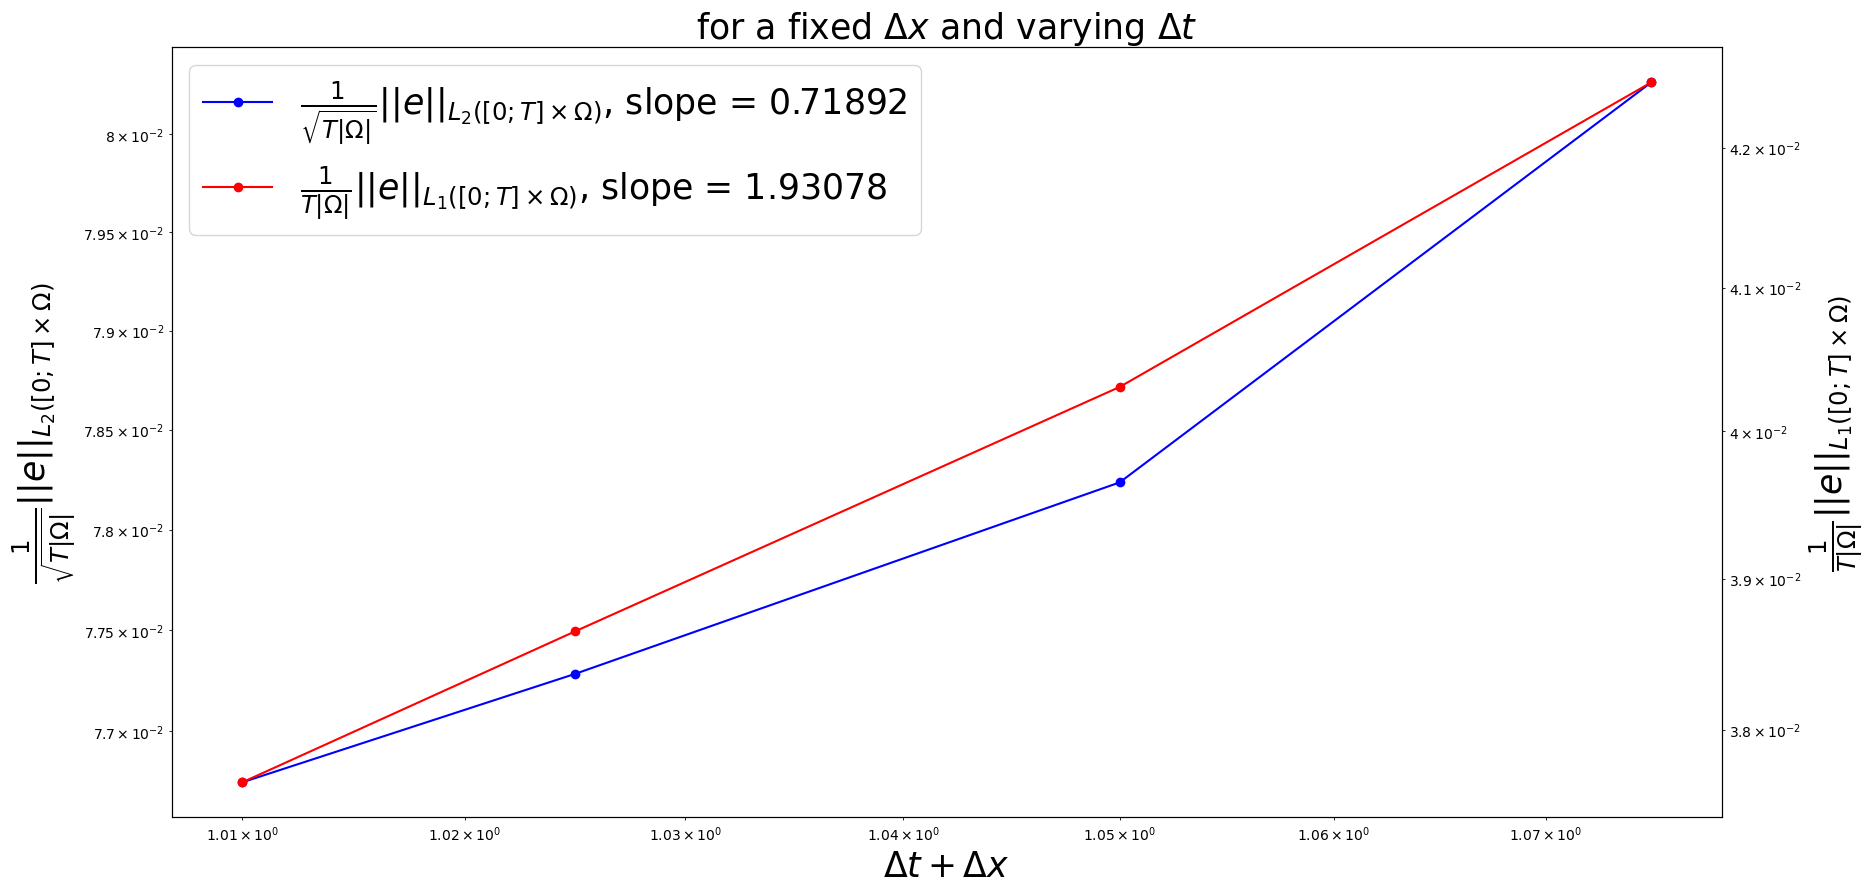

In [22]:
slope_RMSE_vs_time_step = ( np.log(RMSE_vs_time_step[0]) - np.log(RMSE_vs_time_step[-1]) ) / ( np.log(dt_a[0]+msh.dx) - np.log(dt_a[-1]+msh.dx) ) 
slope_MAE_vs_time_step = ( np.log(MAE_vs_time_step[0]) - np.log(MAE_vs_time_step[-1]) ) / ( np.log(dt_a[0]+msh.dx) - np.log(dt_a[-1]+msh.dx) ) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(dt_a+msh.dx,RMSE_vs_time_step,'-ob',label=r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE_vs_time_step)}')
ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$', fontsize=fontsize)
ax1.set_xlabel('$\Delta t + \Delta x$', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(r'for a fixed $\Delta x$ and varying $\Delta t$', fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(dt_a+msh.dx,MAE_vs_time_step,'-or',label=r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE_vs_time_step)}')
ax2.tick_params(axis='both',labelsize=fontsize-5)
ax2.set_ylabel(r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$', fontsize=fontsize)
ax2.set_yscale('log')

line1, label1 = ax1.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2,label1+label2,loc='upper left',prop={'size': fontsize})

### Analysis of the error estimate for several space steps

In [15]:
coeff_dx_a = [0.5, 1., 1.5, 2.]
dx_a = np.zeros((len(coeff_dx_a)))

RMSE_vs_space_step = np.zeros((len(coeff_dx_a)))
MAE_vs_space_step = np.zeros((len(coeff_dx_a)))


for i, coeff_dx in enumerate(coeff_dx_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x * coeff_dx, Delta_y * coeff_dx, T_final)
    
    model_direct = EDP(msh, 0.0025)
    
    c_ref = c_reference(msh)
    
    dx_a[i] = msh.dx
    print("")
    print("dx = ", msh.dx)
    print("dt = ", msh.dt)
    print("")
    
    _, c_solver = model_direct.solver()
    
    RMSE_vs_space_step[i] = npl.norm(c_solver - c_ref) / np.sqrt(c_solver.size)
    MAE_vs_space_step[i] = np.mean(np.abs(c_solver - c_ref))


dx =  0.5
dt =  0.0025
t = 2.000 / 2.000 s
dx =  1.0
dt =  0.0025
t = 2.000 / 2.000 s
dx =  1.5
dt =  0.0025
t = 2.000 / 2.000 s
dx =  2.0
dt =  0.0025
t = 2.000 / 2.000 s

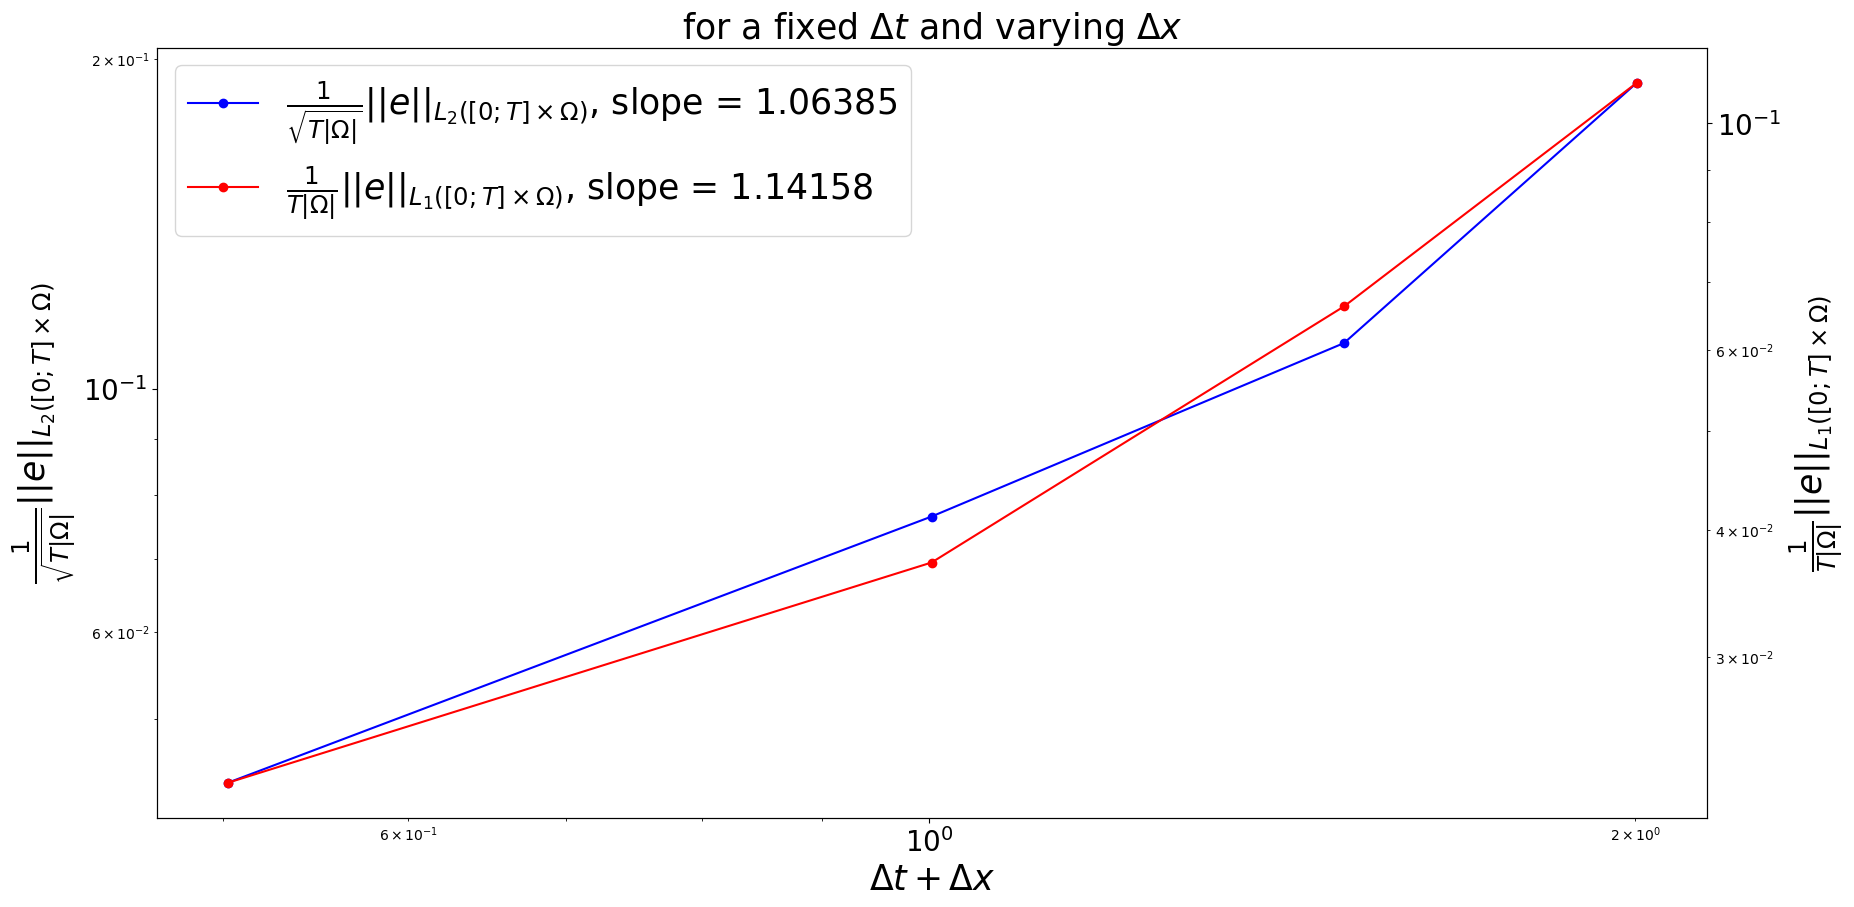

In [17]:
slope_RMSE_vs_space_step = ( np.log(RMSE_vs_space_step[0]) - np.log(RMSE_vs_space_step[-1]) ) / ( np.log(dx_a[0]+msh.dt) - np.log(dx_a[-1]+msh.dt) ) 
slope_MAE_vs_space_step = ( np.log(MAE_vs_space_step[0]) - np.log(MAE_vs_space_step[-1]) ) / ( np.log(dx_a[0]+msh.dt) - np.log(dx_a[-1]+msh.dt) ) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(dx_a+msh.dt,RMSE_vs_space_step,'-ob',label=r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE_vs_space_step)}')
ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$', fontsize=fontsize)
ax1.set_xlabel('$\Delta t + \Delta x$', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(r'for a fixed $\Delta t$ and varying $\Delta x$', fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(dx_a+msh.dt,MAE_vs_space_step,'-or',label=r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE_vs_space_step)}')
ax2.tick_params(axis='both',labelsize=fontsize-5)
ax2.set_ylabel(r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$', fontsize=fontsize)
ax2.set_yscale('log')

line1, label1 = ax1.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2,label1+label2,loc='upper left',prop={'size': fontsize})